# Data Pre-Processing
## Import Libraries

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Import Cleaned Dataset

In [47]:
df = pd.read_csv('Data/cleaned.csv')

In [48]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,inn00001,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,2,offline,0,0,0,65.00,0,not_canceled
1,inn00002,2,0,2,3,not selected,0,room_type 1,5,2018,11,6,online,0,0,0,106.68,1,not_canceled
2,inn00003,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,28,online,0,0,0,60.00,0,canceled
3,inn00004,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,20,online,0,0,0,100.00,0,canceled
4,inn00005,2,0,1,1,not selected,0,room_type 1,48,2018,4,11,online,0,0,0,94.50,0,canceled


In [49]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

# Data Preprocessing

## Train-Test Split

There are two possible methods for train-test split:
1. Randomly split with 80/20 rule
2. Split base on booking date, such that entries in earlier dates will be under training set and those in later dates will be under test set

We will adopt method 2, because in real-life senarios, we are likely to use only historical data to make prediction for future data. At the same time, the size of training and test set will be around 80:20.

In [50]:
# create booking_date
temp = df.rename(columns={
    'arrival_year': 'year',
    'arrival_month': 'month',
    'arrival_date': 'day'
})

df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
df['booking_date'] = df['booking_date'] - pd.Series(
    [pd.Timedelta(i, 'd') for i in df.lead_time],
    index=df.index
)

In [51]:
# split based on booking_date
train = df[df['booking_date']<'2018-07-01'].reset_index(drop=True)
test = df[df['booking_date']>='2018-07-01'].reset_index(drop=True)

In [52]:
print(f'Size of training set: {len(train)}')
print(f'Size of test set: {len(test)}')

Size of training set: 28062
Size of test set: 8176


## Preprocessing on Categorical Variables

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36238 entries, 0 to 36237
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Booking_ID                            36238 non-null  object        
 1   no_of_adults                          36238 non-null  int64         
 2   no_of_children                        36238 non-null  int64         
 3   no_of_weekend_nights                  36238 non-null  int64         
 4   no_of_week_nights                     36238 non-null  int64         
 5   type_of_meal_plan                     36238 non-null  object        
 6   required_car_parking_space            36238 non-null  int64         
 7   room_type_reserved                    36238 non-null  object        
 8   lead_time                             36238 non-null  int64         
 9   arrival_year                          36238 non-null  int64         
 10

From the above info, we can see that in the dataset, we have many categorical attributes. In order to perform classification, additional data preprocessing has to be done. Let's take a look at the attributes that are non-numerical (Categorical)

In [54]:
df.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).head()

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status,booking_date
0,inn00001,meal plan 1,room_type 1,offline,not_canceled,2017-02-20
1,inn00002,not selected,room_type 1,online,not_canceled,2018-11-01
2,inn00003,meal plan 1,room_type 1,online,canceled,2018-02-27
3,inn00004,meal plan 1,room_type 1,online,canceled,2017-10-21
4,inn00005,not selected,room_type 1,online,canceled,2018-02-22


Let's also explore what are the possible values given the different categorical attributes. From this, we can identify nominal and ordinal categories, this is important since we would use different preprocessing method depending on the category type.

For example, for <b>ordinal data</b> (e.g. Low, med high), there is a natural order to the data, and hence we could replace the values using ordinal encoding, where we map each category with numbers to represent that order.

For <b>nominal data</b> (e.g. Red Blue Green), there is no natural order, we cannot simply apply the same strategy as above, since that would imply an artificial order for the data, which is not true. In this case, a strategy we could use is one-hot encoding.

In [88]:
print("Booking_ID unique values: ", df['Booking_ID'].unique(), "\n")
print("type_of_meal_plan unique values: ", df['type_of_meal_plan'].unique(), "\n")
print("room_type_reserved unique values: ", df['room_type_reserved'].unique(), "\n")
print("market_segment_type unique values: ", df['market_segment_type'].unique(), "\n")
print("booking_status unique values: ", df['booking_status'].unique(), "\n")

Booking_ID unique values:  ['inn00001' 'inn00002' 'inn00003' ... 'inn36273' 'inn36274' 'inn36275'] 

type_of_meal_plan unique values:  ['meal plan 1' 'not selected' 'meal plan 2' 'meal plan 3'] 

room_type_reserved unique values:  ['room_type 1' 'room_type 4' 'room_type 2' 'room_type 6' 'room_type 5'
 'room_type 7' 'room_type 3'] 

market_segment_type unique values:  ['offline' 'online' 'corporate' 'aviation' 'complementary'] 

booking_status unique values:  ['not_canceled' 'canceled'] 

arrival_month unique values:  [10 11  2  5  4  9 12  7  6  8  3  1] 



### Based on results, we can see a few observations:
1. Each Booking_ID is unique for each row, this attribute is only used as an identifier to a row, this also means that these are arbitrary values that do not contain any information that helps the model learn patterns related to the target variable, hence we can actually exclude this attribute during our model training.
2. All of the categories appears to be of nominal data type, where there is no real natural order, hence a good strategy we can use here would be one-hot encoding. One-hot encoding creates a binary column for each category and gives a 1 or 0 value to indicate true or false.
3. For Booking_Status, this is actually our target attribute, it only has two possible values (canceled and not_canceled), in this case, we can just use a label encoding to transform the values into a binary value (1 and 0).

In [56]:
# Drop the Booking_ID column as this will not be helpful in training the classification model.
train = train.drop('Booking_ID', axis = 1)
test = test.drop('Booking_ID', axis = 1)

In [57]:
# Encode booking_status
train['booking_status'] = train['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)
test['booking_status'] = test['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)

Hence we have the remaining categorical columns to preprocess:

In [58]:
# Categoriy columns that needs to be preprocessed for classification
cat_cols_to_be_encoded = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'arrival_month']

# Category columns that are already in the binary format (distinct 0 and 1 values)
cat_cols_already_in_the_right_format = ['required_car_parking_space', 'repeated_guest']


There are several ways for encoding categorical varaibles:
1. <b>OrdinalEncoder</b>: Preserves the ordinal relationship between categories, useful when the categorical variables have an inherent order
2. <b>OneHotEncoder</b>: Creates binary columns for each category, indicating the presence or absence of each category, suitable for nominal data with no ordinal relationship
3. <b>TargetEncoder</b>: Replaces categories with the mean of the target variable for each category, useful for high-cardinality categorical variables
4. <b>FrequencyEncoding</b>: Encodes categorical variables based on the frequency of each category in the dataset, useful when the frequency of occurrence is informative, but can lead to information loss

For the above variables, they have small cardinalities and are nominal data, so OneHotEncoding is the most suitable method.

In [59]:
# fit on training data
enc = OneHotEncoder(handle_unknown='error')
enc.fit(train[cat_cols_to_be_encoded])
train[enc.get_feature_names_out()] = enc.transform(train[cat_cols_to_be_encoded]).toarray()

#train.drop(columns=cat_cols_to_be_encoded, inplace=True)

In [60]:
# transform test data
test[enc.get_feature_names_out()] = enc.transform(test[cat_cols_to_be_encoded]).toarray()

#test.drop(columns=cat_cols_to_be_encoded, inplace=True)

In [61]:
# store the categorical column names after encoding
encoded_cat_cols = enc.get_feature_names_out()

# append the encoded_cat_cols with the columns that are already in the right format
encoded_cat_cols = np.append(encoded_cat_cols, cat_cols_already_in_the_right_format)
encoded_cat_cols

array(['type_of_meal_plan_meal plan 1', 'type_of_meal_plan_meal plan 2',
       'type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected',
       'room_type_reserved_room_type 1', 'room_type_reserved_room_type 2',
       'room_type_reserved_room_type 3', 'room_type_reserved_room_type 4',
       'room_type_reserved_room_type 5', 'room_type_reserved_room_type 6',
       'room_type_reserved_room_type 7', 'market_segment_type_aviation',
       'market_segment_type_complementary',
       'market_segment_type_corporate', 'market_segment_type_offline',
       'market_segment_type_online', 'arrival_month_1', 'arrival_month_2',
       'arrival_month_3', 'arrival_month_4', 'arrival_month_5',
       'arrival_month_6', 'arrival_month_7', 'arrival_month_8',
       'arrival_month_9', 'arrival_month_10', 'arrival_month_11',
       'arrival_month_12', 'required_car_parking_space', 'repeated_guest'],
      dtype=object)

For now, all categories are kept to ensure interpretability. To avoid multicollinearity issues in linear models, extra steps can be done to remove some of the attributes.

In [62]:
# Quick Peek at the dataset after categorical preprocessing to verify one hot encoding is successful.
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,arrival_month_3,arrival_month_4,arrival_month_5,arrival_month_6,arrival_month_7,arrival_month_8,arrival_month_9,arrival_month_10,arrival_month_11,arrival_month_12
0,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,1,1,not selected,0,room_type 1,48,2018,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,0,2,meal plan 2,0,room_type 1,346,2018,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Feature Engineering on Numerical Variables

There are 2 possible methods to handle numerical variables:
1. Discretize the variables into a few categories. While this method can improve interpretability and reduce sensitivity to outliers, it may cause information loss
2. Scale the variables to facilitate algorithms that require gradient descent or distance measurement

In the following sections, the 2 methods will be implemented separately, and they will be fed into a logistic regression model to compare the performance.

### Discretization

The following variables have fewer unique values and will be visualized with countplots.

In [63]:
spec_num_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']

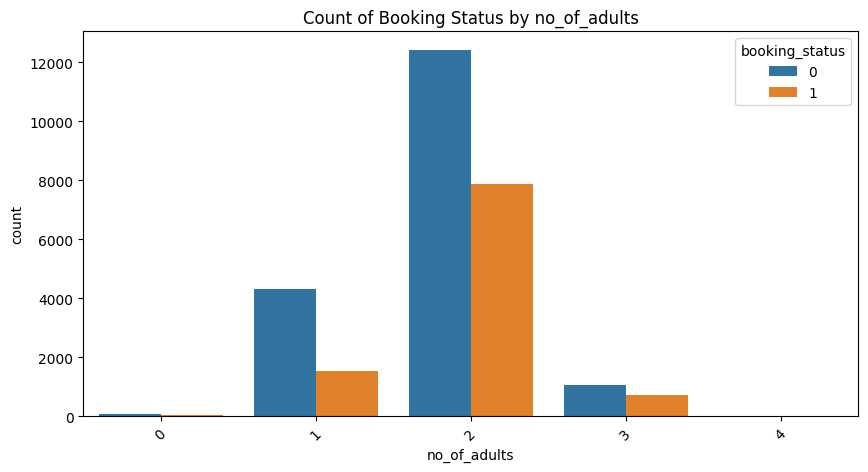

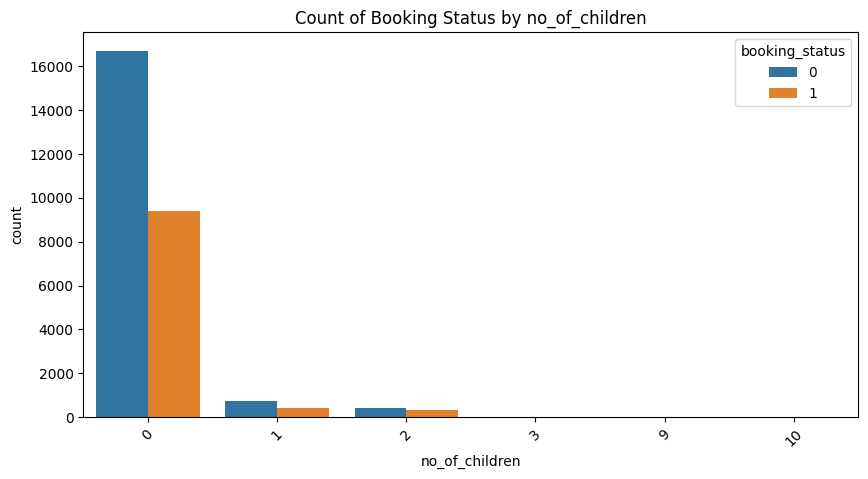

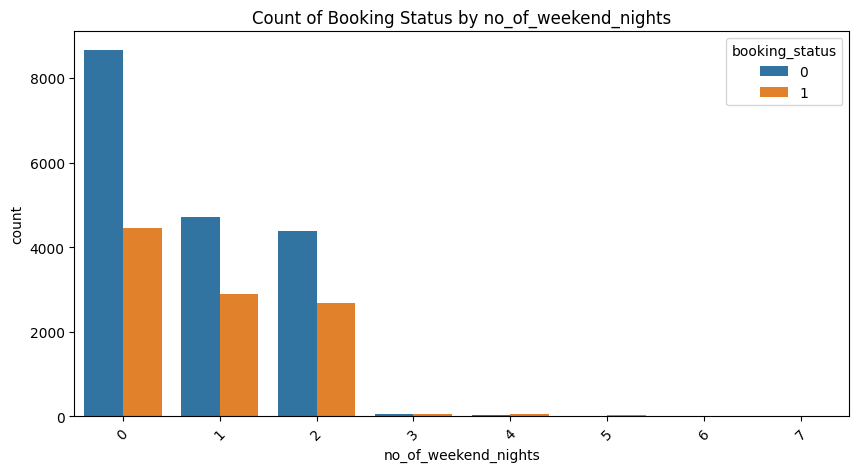

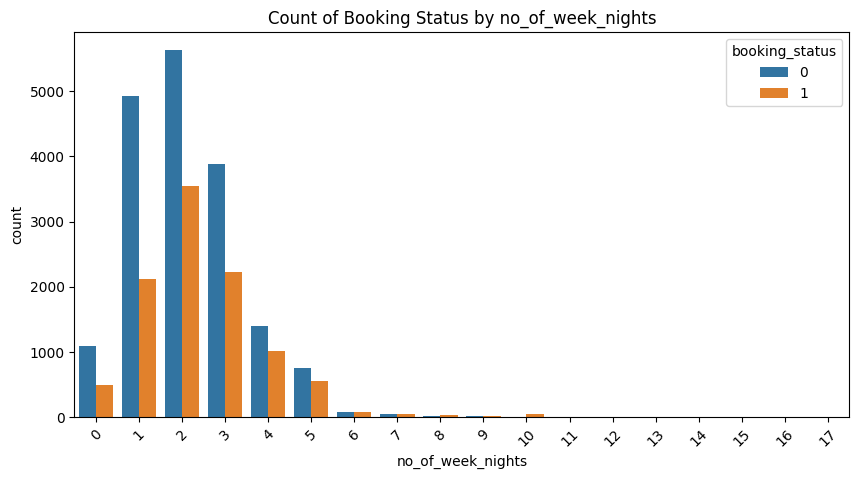

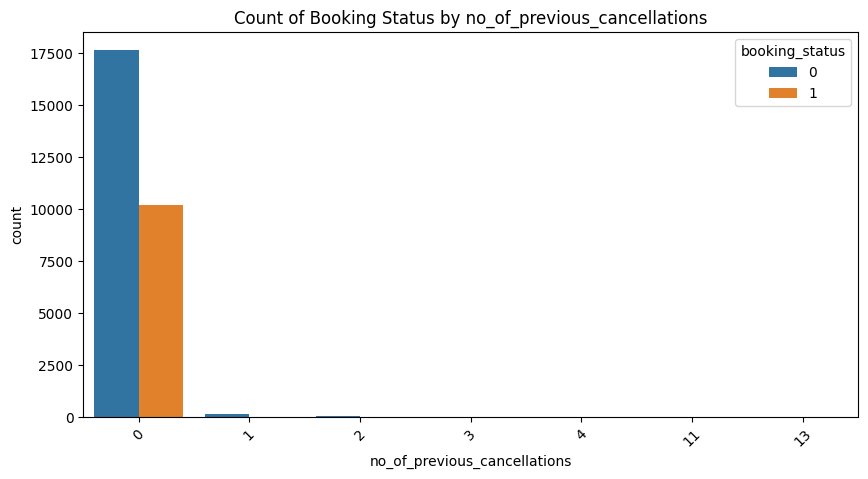

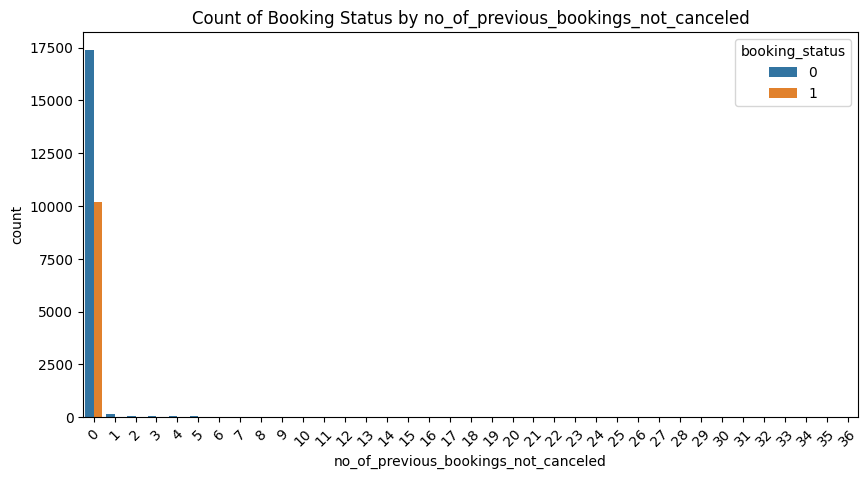

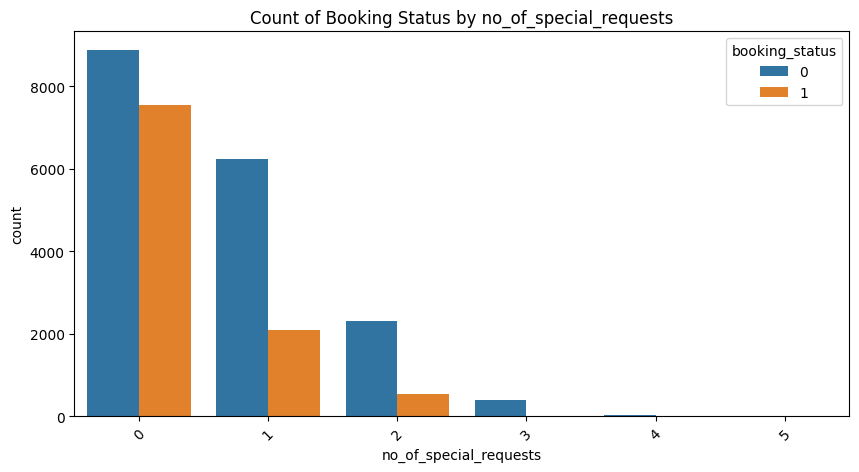

In [64]:
for col in spec_num_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=train)
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

With the above visualizations, the following rules will be implemented to reduce the effect of outliers:
1. no_of_adults: observations with no_of_adults>3 will be group into one category, while 0, 1, 2, 3 will be separate categories
2. no_of_children: observations with no_of_children>2 will be group into one category, while 0, 1, 2 will be separate categories
3. no_of_weekend_nights: observations with no_of_weekend_nights>2 will be group into one category, while 0, 1, 2 will be separate categories
4. no_of_week_nights: observations with no_of_week_nights>7 will be group into one category, while the others will be separate categories
5. no_of_previous_cancellations: this variable will be converted to a boolean variable, i.e. whether or not cancelled before
6. no_of_previous_bookings_not_canceled: this variable will be converted to a boolean variable, i.e. whether or not had uncancelled bookings before
7. no_of_special_requests: observations with no_of_special_requests>2 will be group into one category, while 0, 1, 2 will be separate categories

In [65]:
# no_of_adults: create a >3 category
train['no_of_adults_cat'] = train['no_of_adults'].apply(lambda x: str(x) if x<=3 else 'greater than 3')

# no_of_children: create a >2 category
train['no_of_children_cat'] = train['no_of_children'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_weekend_nights: create a >2 category -> stay for more than one week
train['no_of_weekend_nights_cat'] = train['no_of_weekend_nights'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_week_nights: create a >7 category -> stay for more than one week
train['no_of_week_nights_cat'] = train['no_of_week_nights'].apply(lambda x: str(x) if x<=7 else 'greater than 7')

# no_of_previous_cancellations: convert to binary
train['no_of_previous_cancellations_cat'] = train['no_of_previous_cancellations'].apply(lambda x: x if x==0 else 1)

# no_of_previous_bookings_not_canceled: convert to binary
train['no_of_previous_bookings_not_canceled_cat'] = train['no_of_previous_bookings_not_canceled'].apply(lambda x: x if x==0 else 1)

# no_of_special_requests: create a >2 category
train['no_of_special_requests_cat'] = train['no_of_special_requests'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

The following variables have a substantial number of unique values and will be visualized with histplot.

In [66]:
num_cols = ['lead_time', 'avg_price_per_room']

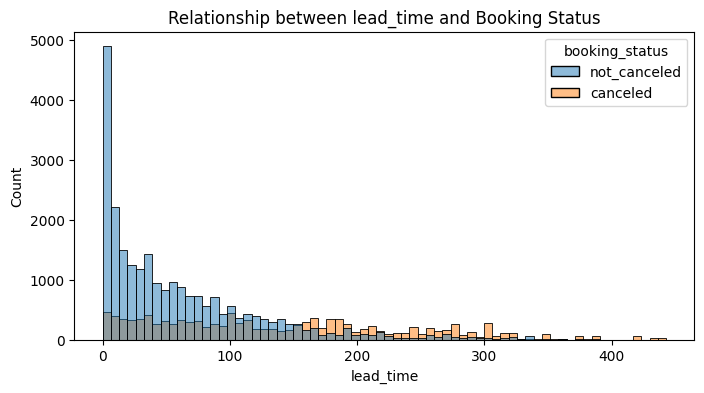

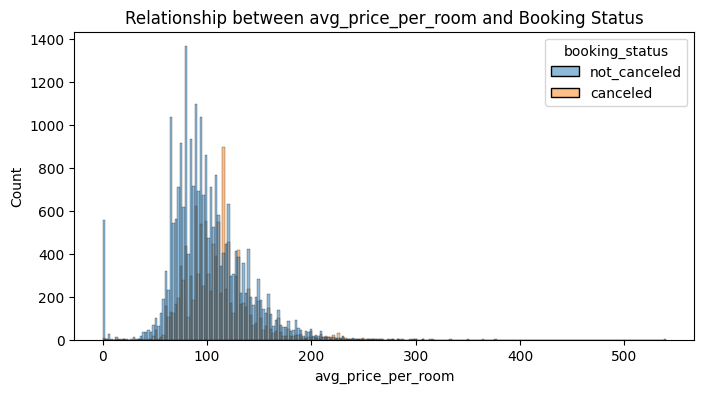

In [67]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(x=col, hue='booking_status', data=df)
    plt.title(f'Relationship between {col} and Booking Status')
    plt.show()

These 2 numerical variables will be binned into: 0 to 50, 50 to 100, 100 to 150, 200 to 300, and greater than 300 categories.

In [68]:
def binning(x):
    if x<=50:
        return 'cat 1: 0 to 50'
    elif x<=100:
        return 'cat 2: 50 to 100'
    elif x<=150:
        return 'cat 3: 100 to 150'
    elif x<=200:
        return 'cat 4: 150 to 200'
    elif x<=300:
        return 'cat 5: 200 to 300'
    else:
        return 'cat 6: greater than 300'

In [69]:
# lead_time
train['lead_time_cat'] = train['lead_time'].apply(binning)

# avg_price_per_room
train['avg_price_per_room_cat'] = train['avg_price_per_room'].apply(binning)

In [70]:
# store the numerical column names after discretization
spec_cat_cols = ['no_of_adults_cat', 'no_of_children_cat', 'no_of_weekend_nights_cat', 'no_of_week_nights_cat', 'no_of_previous_cancellations_cat', 'no_of_previous_bookings_not_canceled_cat', 'no_of_special_requests_cat', 'lead_time_cat', 'avg_price_per_room_cat']

The variables after discretization will be visualized again.

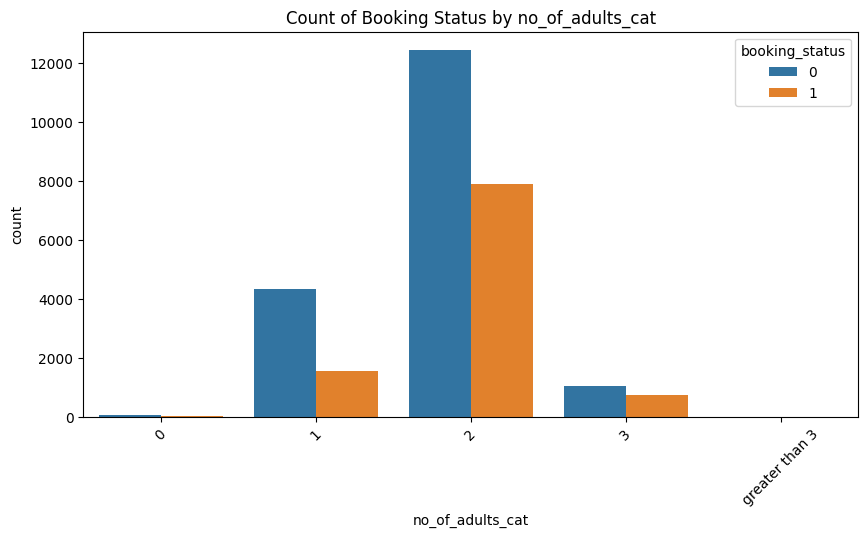

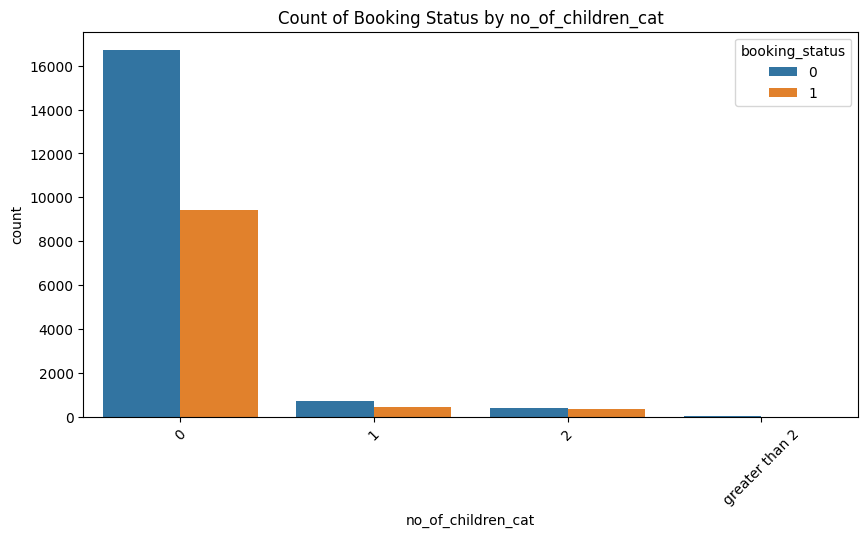

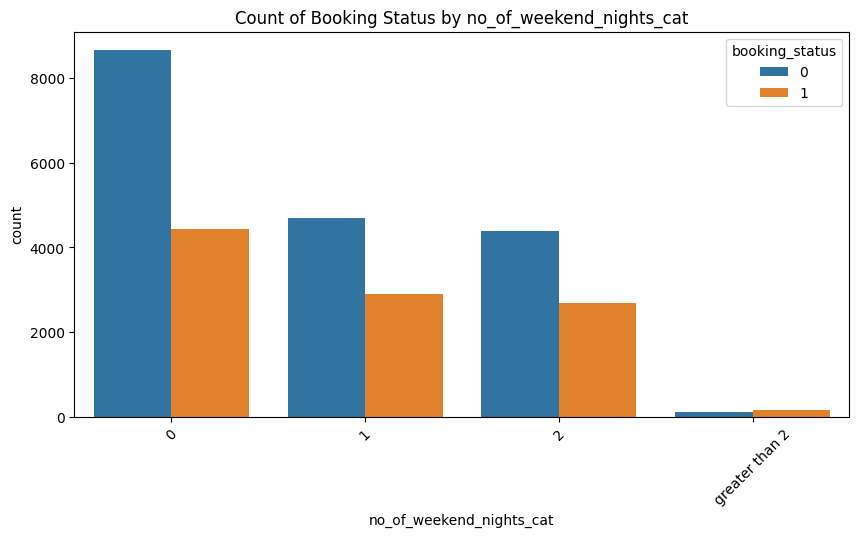

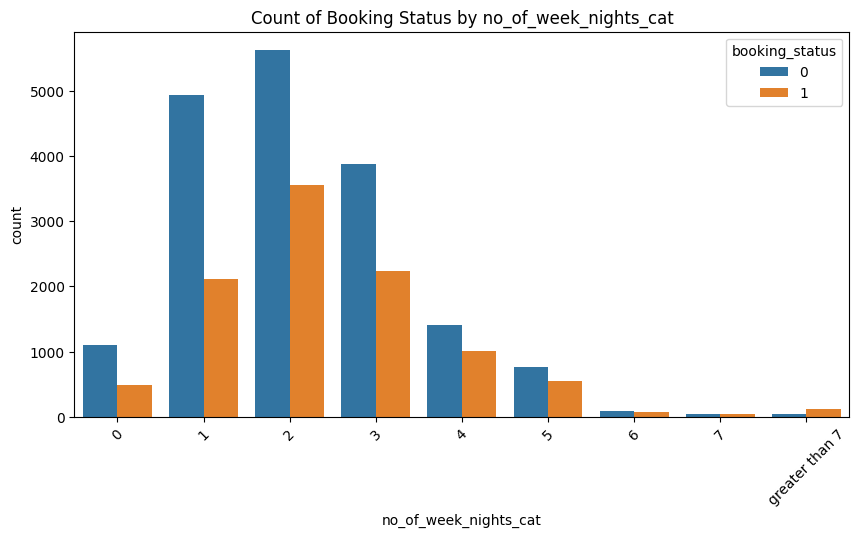

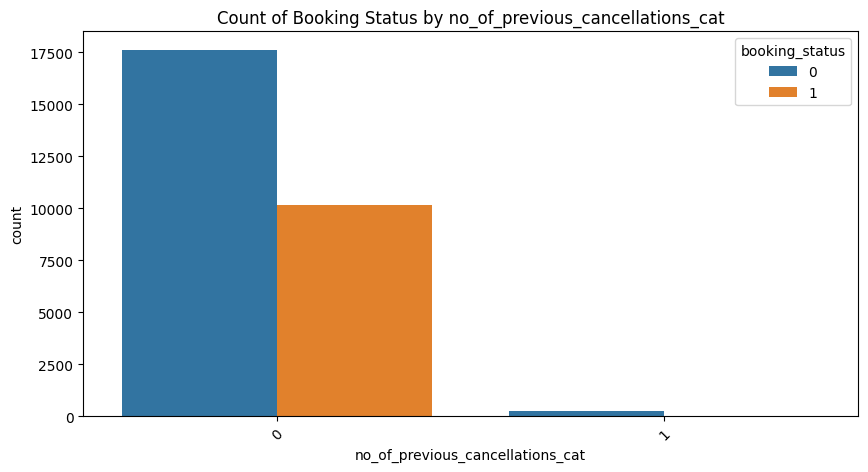

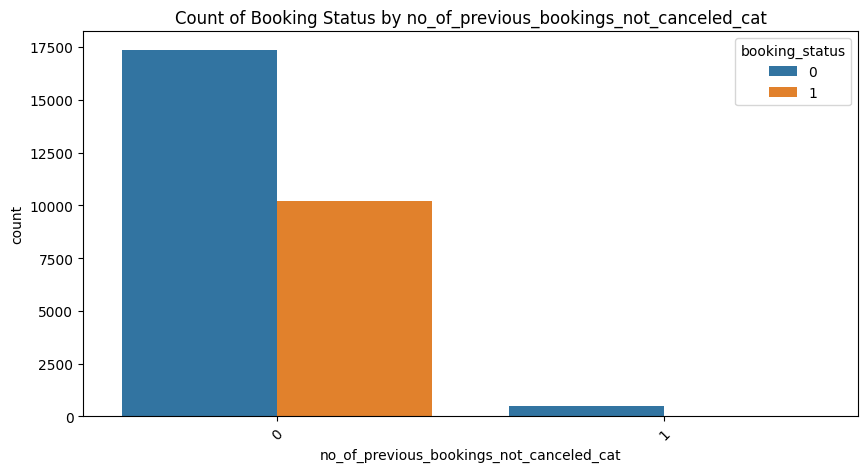

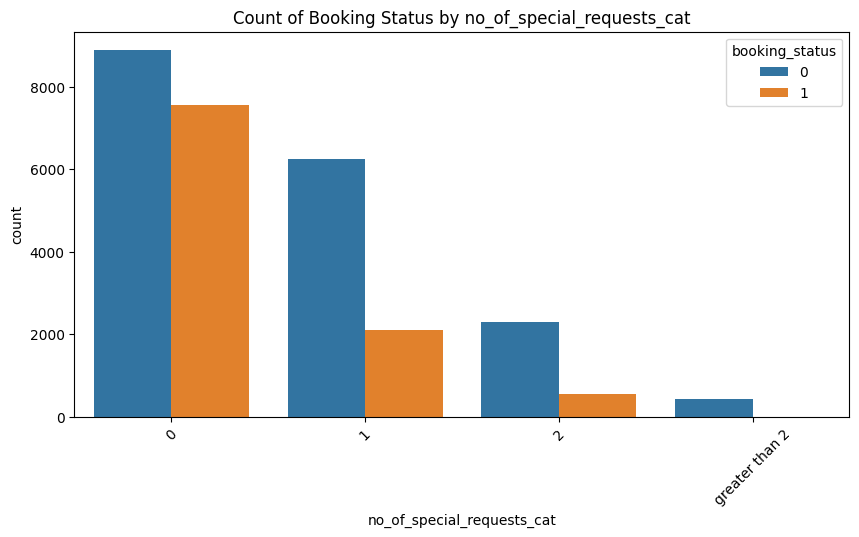

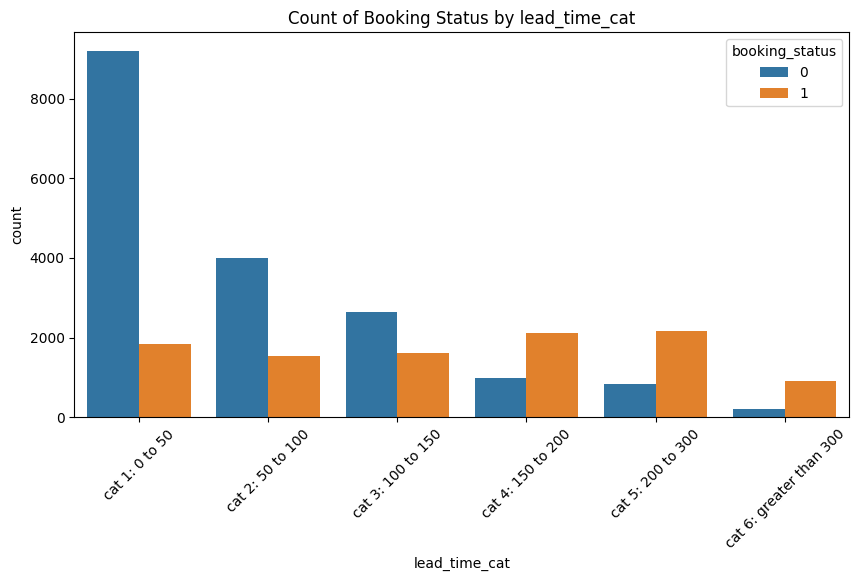

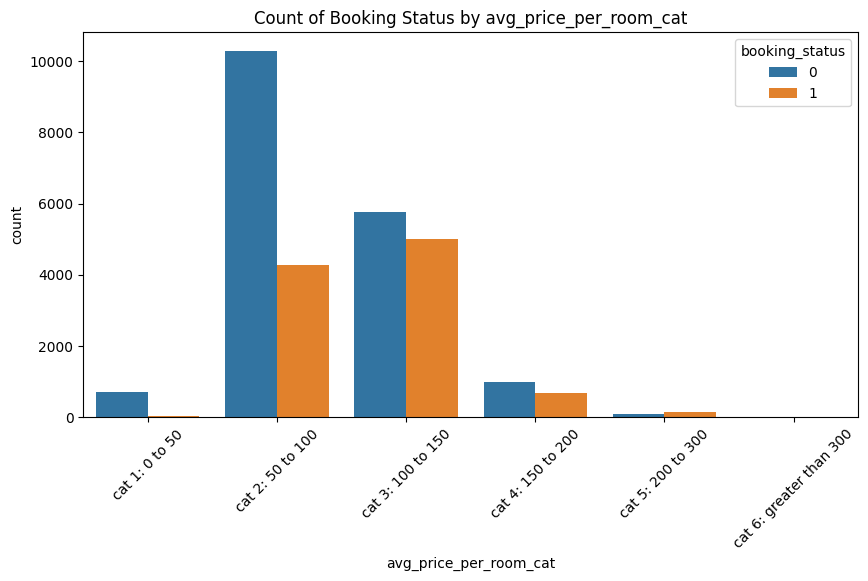

In [71]:
for col in spec_cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=train, order=sorted(train[col].unique()))
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

Test data will be discretized in the same way.

In [72]:
# no_of_adults: create a >3 category
test['no_of_adults_cat'] = test['no_of_adults'].apply(lambda x: str(x) if x<=3 else 'greater than 3')

# no_of_children: create a >2 category
test['no_of_children_cat'] = test['no_of_children'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_weekend_nights: create a >2 category -> stay for more than one week
test['no_of_weekend_nights_cat'] = test['no_of_weekend_nights'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_week_nights: create a >7 category -> stay for more than one week
test['no_of_week_nights_cat'] = test['no_of_week_nights'].apply(lambda x: str(x) if x<=7 else 'greater than 7')

# no_of_previous_cancellations: convert to binary
test['no_of_previous_cancellations_cat'] = test['no_of_previous_cancellations'].apply(lambda x: x if x==0 else 1)

# no_of_previous_bookings_not_canceled: convert to binary
test['no_of_previous_bookings_not_canceled_cat'] = test['no_of_previous_bookings_not_canceled'].apply(lambda x: x if x==0 else 1)

# no_of_special_requests: create a >2 category
test['no_of_special_requests_cat'] = test['no_of_special_requests'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

In [73]:
# lead_time
test['lead_time_cat'] = test['lead_time'].apply(binning)

# avg_price_per_room
test['avg_price_per_room_cat'] = test['avg_price_per_room'].apply(binning)

Again, these categorical variables need to be encoded, and OneHotEncoding will be adopted.

In [74]:
# fit on training data
enc_spec = OneHotEncoder(handle_unknown='error')
enc_spec.fit(train[spec_cat_cols])
train[enc_spec.get_feature_names_out()] = enc_spec.transform(train[spec_cat_cols]).toarray()

train.drop(columns=spec_cat_cols, inplace=True)

In [75]:
# transform test data
test[enc_spec.get_feature_names_out()] = enc_spec.transform(test[spec_cat_cols]).toarray()

test.drop(columns=spec_cat_cols, inplace=True)

In [76]:
# store the numerical column names after encoding
encoded_num_cols = enc_spec.get_feature_names_out()
encoded_num_cols

array(['no_of_adults_cat_0', 'no_of_adults_cat_1', 'no_of_adults_cat_2',
       'no_of_adults_cat_3', 'no_of_adults_cat_greater than 3',
       'no_of_children_cat_0', 'no_of_children_cat_1',
       'no_of_children_cat_2', 'no_of_children_cat_greater than 2',
       'no_of_weekend_nights_cat_0', 'no_of_weekend_nights_cat_1',
       'no_of_weekend_nights_cat_2',
       'no_of_weekend_nights_cat_greater than 2',
       'no_of_week_nights_cat_0', 'no_of_week_nights_cat_1',
       'no_of_week_nights_cat_2', 'no_of_week_nights_cat_3',
       'no_of_week_nights_cat_4', 'no_of_week_nights_cat_5',
       'no_of_week_nights_cat_6', 'no_of_week_nights_cat_7',
       'no_of_week_nights_cat_greater than 7',
       'no_of_previous_cancellations_cat_0',
       'no_of_previous_cancellations_cat_1',
       'no_of_previous_bookings_not_canceled_cat_0',
       'no_of_previous_bookings_not_canceled_cat_1',
       'no_of_special_requests_cat_0', 'no_of_special_requests_cat_1',
       'no_of_special_reques

### Scaling

For machine learning algorithm that requires gradient descent or distance measurement, feature scaling is necessary. There are several ways of scaling:
1. Min-Max Scaling: Scales the data to a fixed range, usually between 0 and 1, useful when the distribution of data is uniform or when the algorithm requires input features to be on a similar scale
2. Standardization: Scales the data to have a mean of 0 and a standard deviation of 1, preserves the shape of the original distribution and is less affected by outliers
3. Robust Scaling: Scales the data based on the interquartile range (IQR) to mitigate the effect of outliers

As observations with extreme values exist in our data and the distribution of data is not of a specific distribution, we will adopt Standardization.

In [77]:
# fit on training data
scaler = StandardScaler()
scaler.fit(train[spec_num_cols+num_cols])
train[[x+'_scaled' for x in spec_num_cols+num_cols]] = scaler.transform(train[spec_num_cols+num_cols])

In [78]:
# transform test data
test[[x+'_scaled' for x in spec_num_cols+num_cols]] = scaler.transform(test[spec_num_cols+num_cols])

In [79]:
# store the numerical column names after scaling
scaled_num_cols = [x+'_scaled' for x in spec_num_cols+num_cols]
scaled_num_cols

['no_of_adults_scaled',
 'no_of_children_scaled',
 'no_of_weekend_nights_scaled',
 'no_of_week_nights_scaled',
 'no_of_previous_cancellations_scaled',
 'no_of_previous_bookings_not_canceled_scaled',
 'no_of_special_requests_scaled',
 'lead_time_scaled',
 'avg_price_per_room_scaled']

## Examination with Logistic Regression

Train and test set will first be prepared for model building. Then a logistic regression will be fitted to the 2 sets of processed data and compared the performance:
1. encoded categorical variables + discretized and encoded numerical variables
2. encoded categorical variables + scaled numerical variables

In [80]:
X_train = train.drop(['booking_status'], axis = 1)
Y_train = train['booking_status']
X_test = test.drop(['booking_status'], axis = 1)
Y_test = test['booking_status']

In [81]:
X_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,avg_price_per_room_cat_cat 6: greater than 300,no_of_adults_scaled,no_of_children_scaled,no_of_weekend_nights_scaled,no_of_week_nights_scaled,no_of_previous_cancellations_scaled,no_of_previous_bookings_not_canceled_scaled,no_of_special_requests_scaled,lead_time_scaled,avg_price_per_room_scaled
0,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,...,0.0,0.294807,-0.249422,0.216298,-0.179429,-0.060459,-0.090352,-0.736764,1.363410,-1.078369
1,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,...,0.0,-1.645814,-0.249422,1.360457,-0.890405,-0.060459,-0.090352,-0.736764,-1.076089,-1.229683
2,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,...,0.0,0.294807,-0.249422,-0.927860,-0.179429,-0.060459,-0.090352,-0.736764,1.221197,-0.019170
3,2,0,1,1,not selected,0,room_type 1,48,2018,4,...,0.0,0.294807,-0.249422,0.216298,-0.890405,-0.060459,-0.090352,-0.736764,-0.561935,-0.185616
4,2,0,0,2,meal plan 2,0,room_type 1,346,2018,9,...,0.0,0.294807,-0.249422,-0.927860,-0.179429,-0.060459,-0.090352,0.606122,2.698023,0.434772


### encoded categorical variables + discretized and encoded numerical variables

In [82]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(encoded_num_cols)], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(encoded_num_cols)])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(encoded_num_cols)])

In [83]:

# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8131280735514218
Precision 	: 0.7548373816385344
Recall 		: 0.7193016869360533
F1 Score 	: 0.7366412213740458

**Test Set Metrics**
Accuracy 	: 0.8115215264187867
Precision 	: 0.6038291605301914
Recall 		: 0.2437574316290131
F1 Score 	: 0.34731046166878443


### encoded categorical variables + scaled numerical variables

In [84]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(scaled_num_cols)], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(scaled_num_cols)])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(scaled_num_cols)])

In [85]:
# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8022949183949826
Precision 	: 0.7495168563452866
Recall 		: 0.6846802667712829
F1 Score 	: 0.7156330087134802

**Test Set Metrics**
Accuracy 	: 0.815068493150685
Precision 	: 0.6009501187648456
Recall 		: 0.30083234244946494
F1 Score 	: 0.4009508716323296


From the results, it can be seen that scaling the numerical variables provides us better results. While discretizing all numerical variables do not help improve the performance, individual numerical feature may still be discretized, which will be experimented more under Feature Engineering stage. Now after preprocessing the data, the next step is to train and compare different classification models on our preprocessed data (one-hot encoded and scaled numerical variables.

We will export the train and test dataset to be used by ClassificationModels.ipynb where we will train classification models with the preprocessed data.

In [86]:
original_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests']

In [89]:
X_train[list(encoded_cat_cols)+list(scaled_num_cols)+original_cols].to_csv('Data/X_train.csv', index = False)
Y_train.to_csv('Data/y_train.csv', index = False)
X_test[list(encoded_cat_cols)+list(scaled_num_cols)+original_cols].to_csv('Data/X_test.csv', index = False)
Y_test.to_csv('Data/y_test.csv', index = False)

In [90]:
# store the column names used for model building
columns = pd.DataFrame({'Columns':list(encoded_cat_cols)+list(scaled_num_cols)})

In [92]:
columns.to_csv('Data/basic_model_columns.csv', index=False)